## Install ultralytics

In [1]:
# Install ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.8/486.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 20.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [3]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 1.13.0 (Tesla P100-PCIE-16GB)


In [4]:
images_path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/'

# Try YOLOv8

In [5]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("yolov8m.pt")

  0%|          | 0.00/49.7M [00:00<?, ?B/s]


Found https://i.stack.imgur.com/GRdCC.jpg locally at GRdCC.jpg
image 1/1 /kaggle/working/GRdCC.jpg: 448x640 1 person, 1 bicycle, 5 cars, 1 truck, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


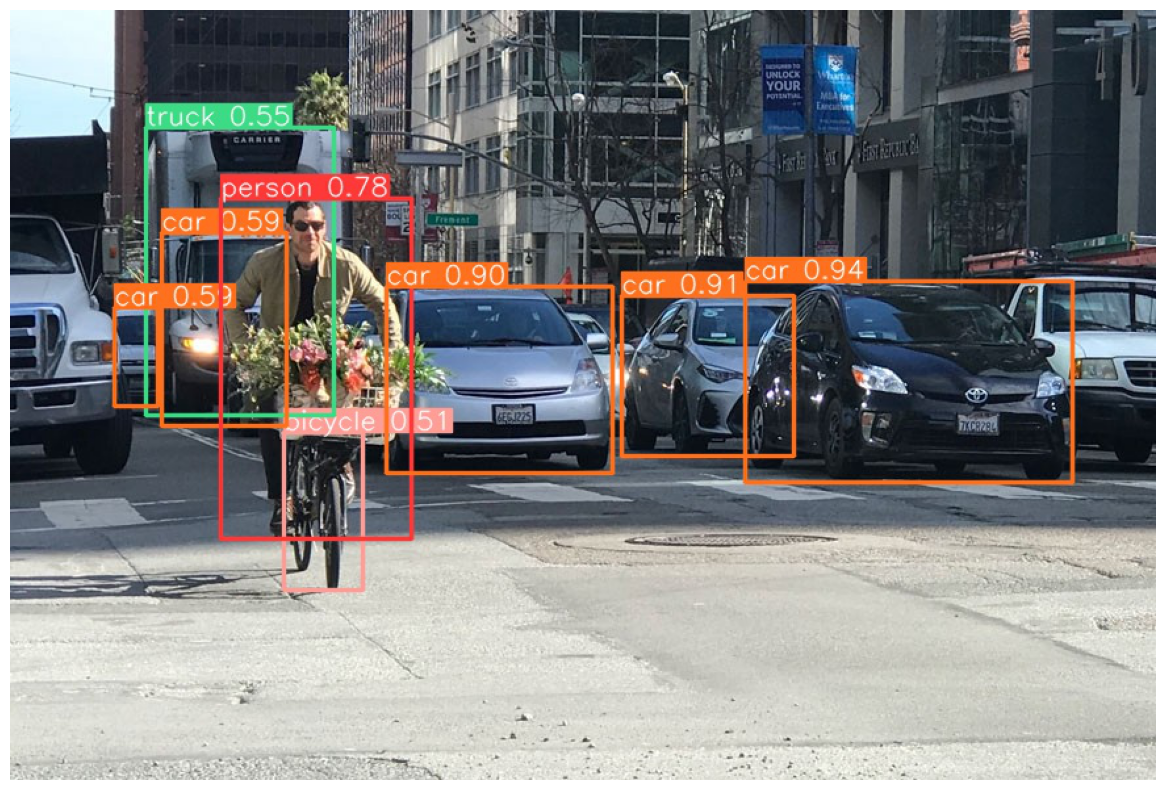

In [9]:
# choose random image
img = random.choice(os.listdir(images_path))

i=detection_model.predict(source='https://i.stack.imgur.com/GRdCC.jpg', conf=0.5, save=True, line_thickness=2, hide_labels=False)

im = plt.imread('/kaggle/working/runs/detect/predict/GRdCC.jpg')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)

# Plot Training Data with Annotations

In [10]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])
            
            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

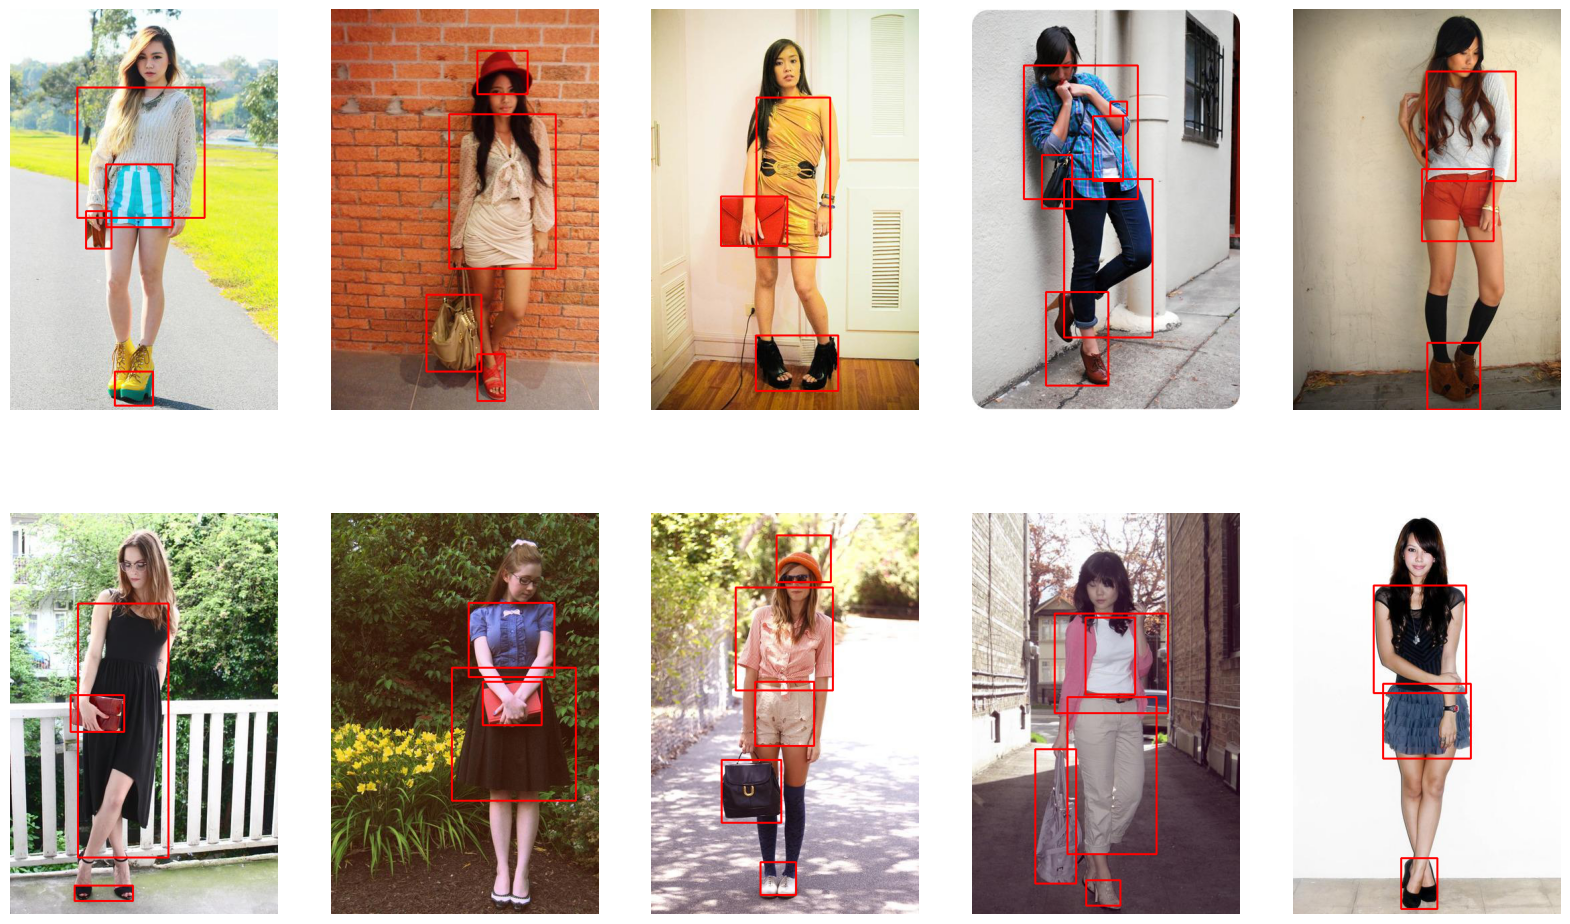

In [11]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(20,12))
ls = os.listdir(images_path)
c = 1
for i in random.sample(ls, 10):
    img = plt.imread(images_path+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(2,5, c)
    plot_annotations(img, i)
    c+=1

# Prepare Dataset

In [13]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [14]:
len(train), len(test)

(2145, 537)

In [15]:
os.mkdir('train')
os.mkdir('train/images')
os.mkdir('train/labels')

os.mkdir('test')
os.mkdir('test/images')
os.mkdir('test/labels')

In [16]:
train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test/'

print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:27<00:00, 79.43it/s]


Copying Test Data..!!


100%|██████████| 537/537 [00:07<00:00, 75.79it/s]


# Train Custom Model

In [17]:
text = """
train: /kaggle/working/train
val: /kaggle/working/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [18]:
model = YOLO("yolov8m.pt")

model.train(data='data.yaml', epochs=5)

Ultralytics YOLOv8.0.58 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.Conv                  [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.Conv                  [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.C2f                   [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.Conv                  [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.C2f                   [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.Conv                  [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.C2f                   [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias
train: Scanning /kaggle/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 2095.27it/s]
train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 2082.32it/s]
val: New cache created: /kaggle/working/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/5      7.51G      1.351      2.144      1.517      

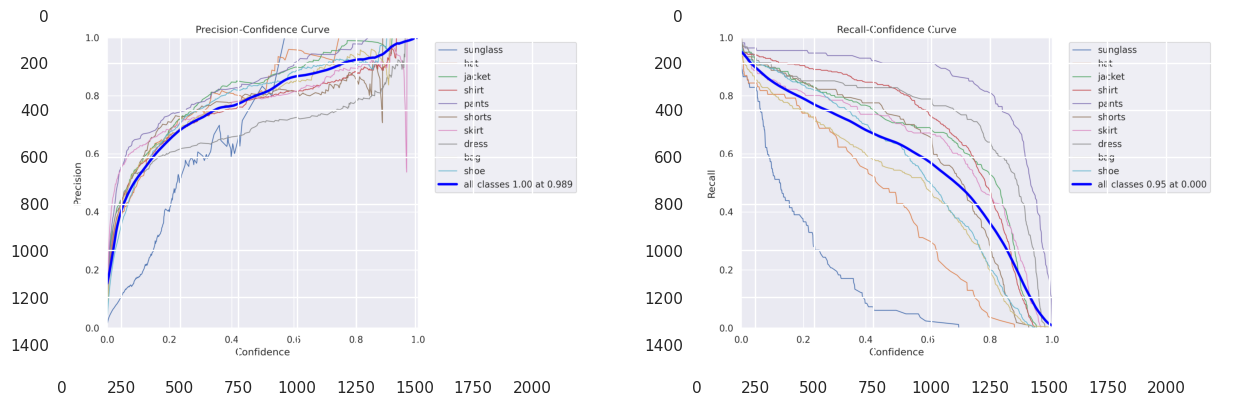

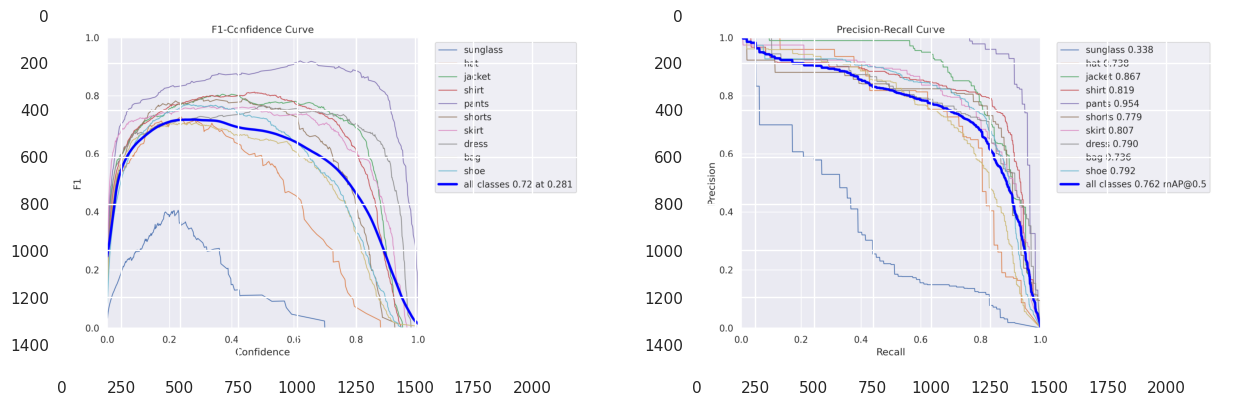

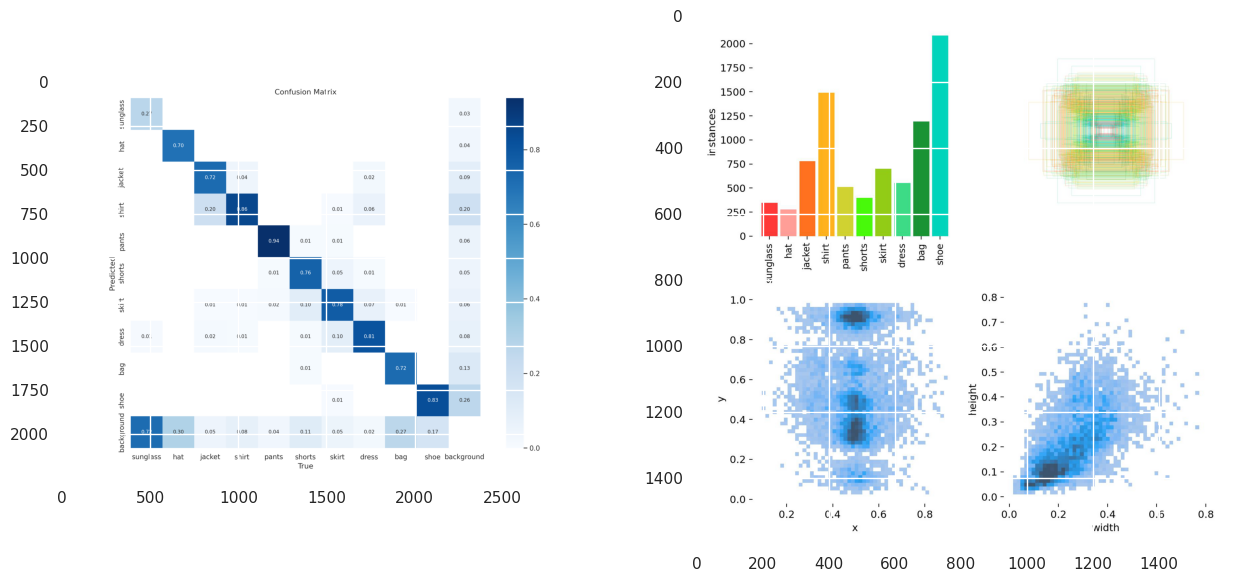

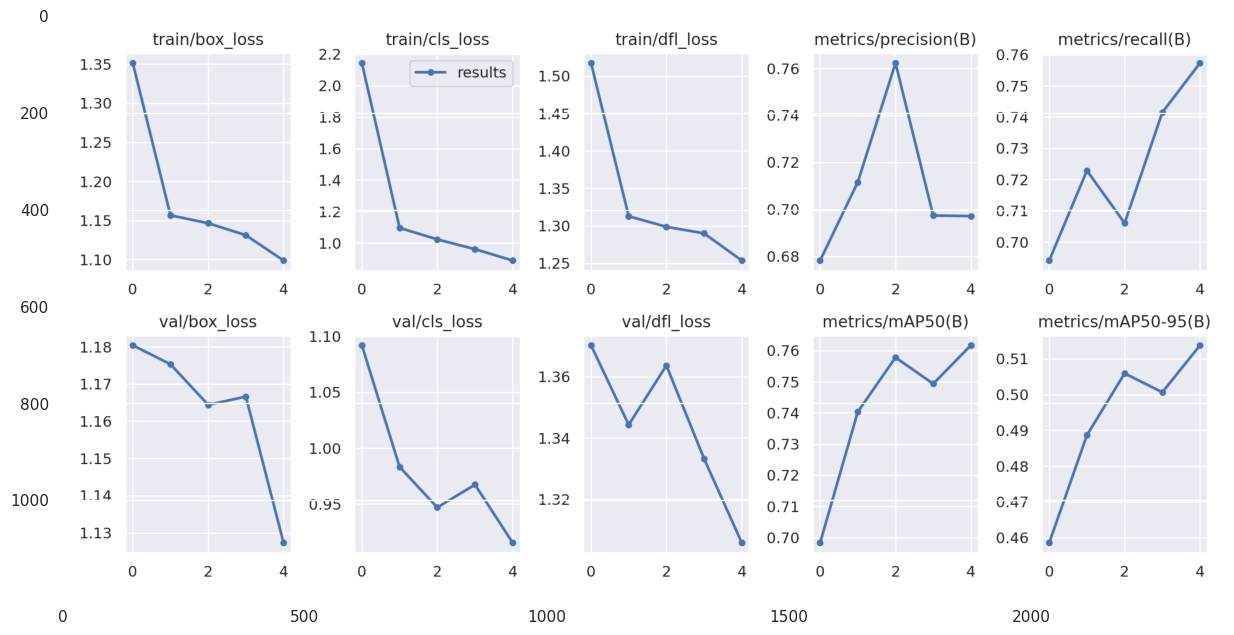

In [24]:
%matplotlib inline
model_path = 'runs/detect/train/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

# Test Model


image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/133549.jpg: 640x448 1 hat, 1 shirt, 1 skirt, 1 shoe, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/17856.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/62639.jpg: 640x448 1 shirt, 1 pants, 1 bag, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2

image 1/1 /kaggle/input/colorful-fashion-data

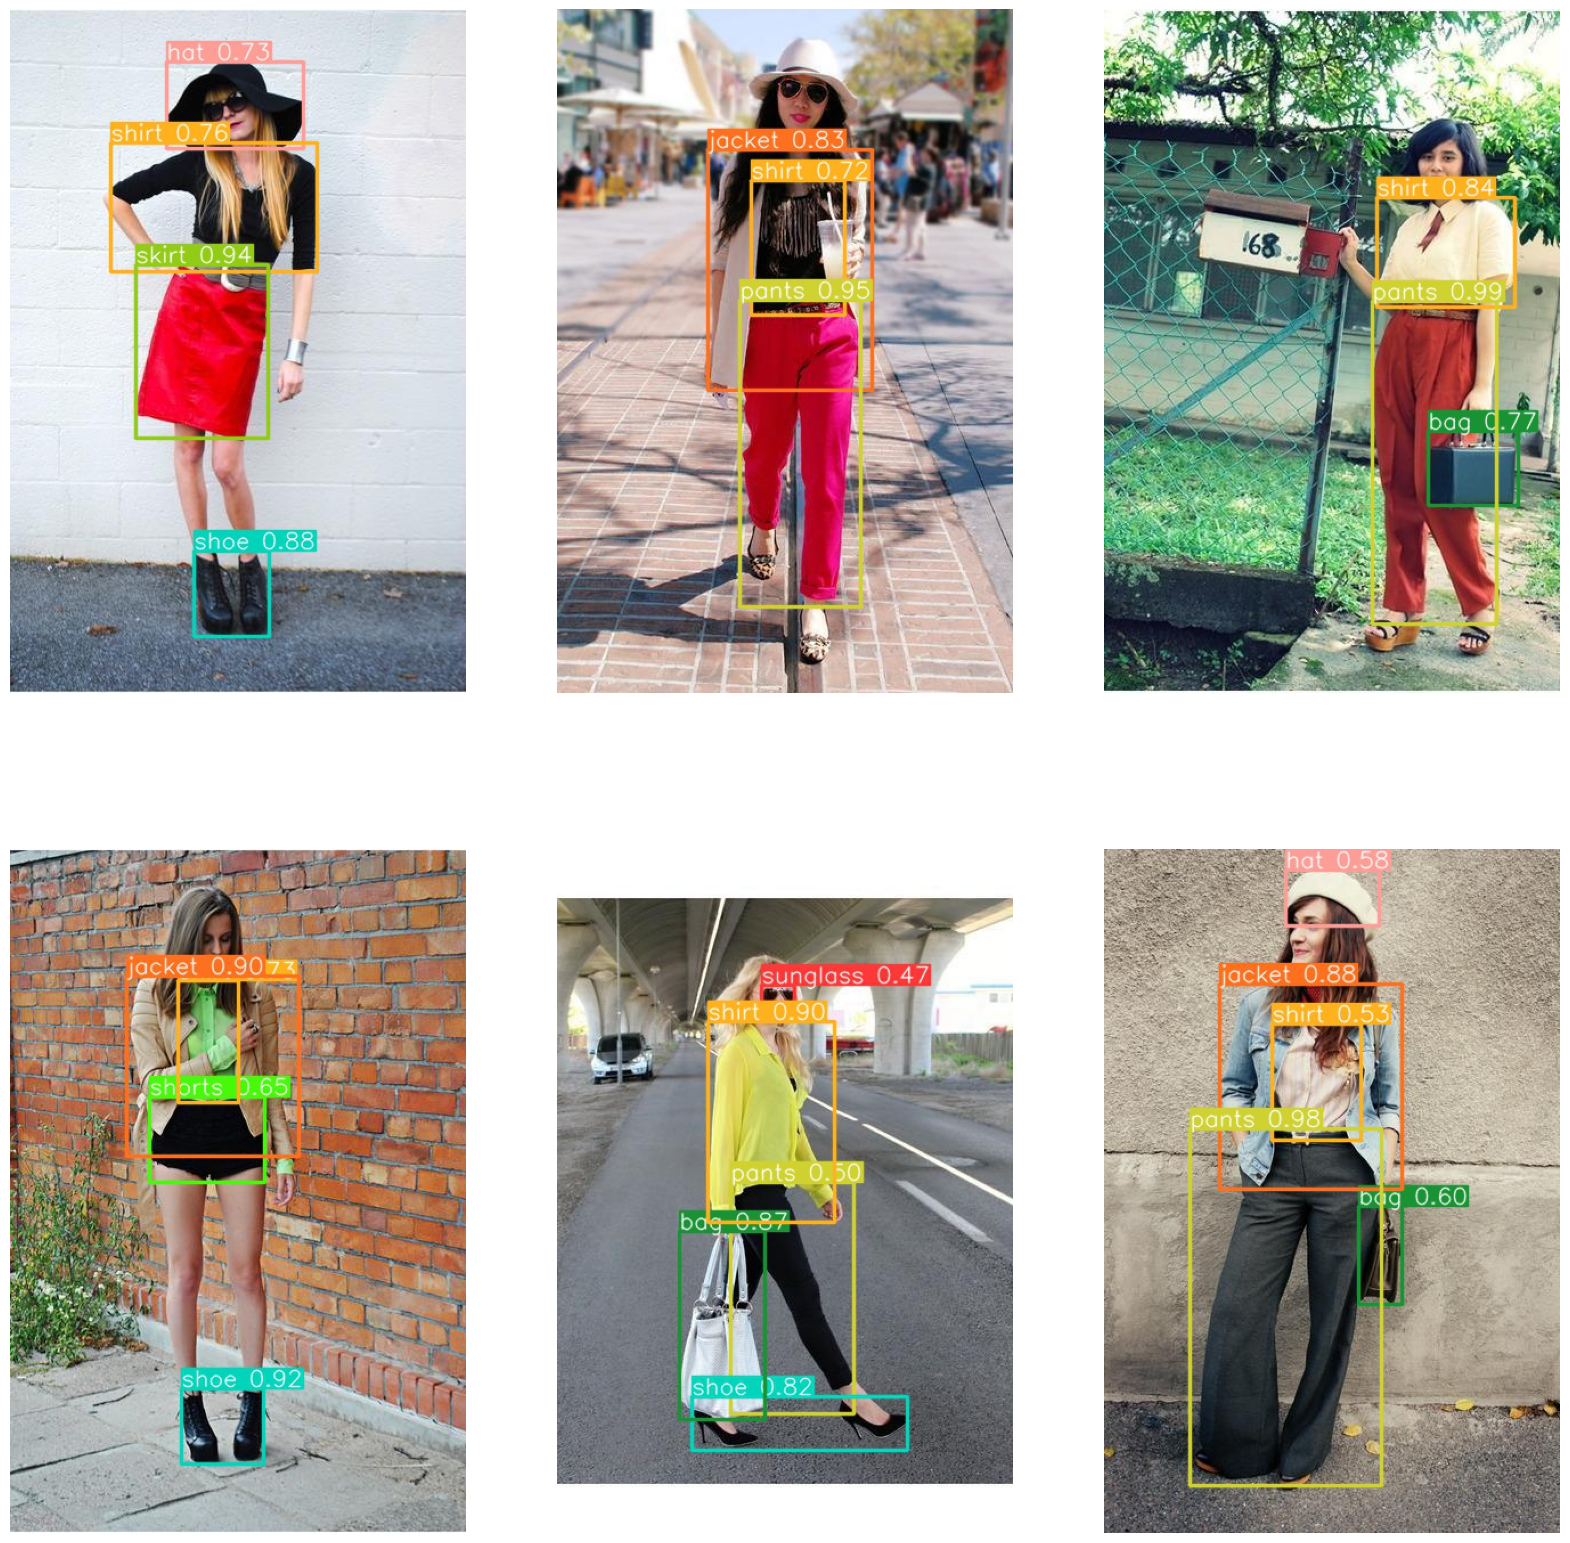

In [25]:
# choose random image from dataset
plt.figure(figsize=(20,20))
imgs = random.sample(os.listdir(images_path), 6)
c=1
for img in imgs:
    i=model.predict(source=images_path+img, conf=0.4, save=True, line_thickness=2)

    im = plt.imread('/kaggle/working/runs/detect/predict2/'+img)
    plt.subplot(2,3,c)
    plt.axis('off')
    plt.imshow(im)
    c+=1